In [ ]:
!pip install rdkit


In [13]:
CUDA_LAUNCH_BLOCKING = "1"
from sklearn.metrics import log_loss, mean_absolute_error, mean_squared_error

import torch
import torchvision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
#from google.colab import drive
import math
import rdkit
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import QED
from rdkit.Chem import MolSurf
from rdkit.Chem import rdFreeSASA as SASA
import os
import seaborn as sb
from dataframe_pipeline_script import Dataset
#drive.mount('/content/drive')

In [2]:
#path = "/content/drive/My Drive/Toxicity Project/DATA/fingerprint_df.csv"
path = "DATA/fingerprint_df.csv"
df = pd.read_csv(path)
df.head()

,index,Unnamed: 0.1,Unnamed: 0,id,title,common_name,description,cas,pubchem_id,chemical_formula,...,fp122,fp123,fp124,fp125,fp126,fp127,fp128,binary_rat_ld50,LD50_level,LD50_rat_level
0,0,0,0,2,T3D0001,Arsenic,Arsenic(As) is a ubiquitous metalloid found in...,7440-38-2,104734.0,As,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0
1,1,1,3,5,T3D0004,Vinyl chloride,"Vinyl chloride is a man-made organic compound,...",75-01-4,6338.0,C2H3Cl,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0
2,2,2,4,7,T3D0006,Benzene,"Benzene is a toxic, volatile, flammable liquid...",71-43-2,241.0,C6H6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,3.0
3,3,3,5,8,T3D0007,Cadmium,Cadmium (group IIB of the periodic table of el...,7440-43-9,31193.0,Cd,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0
4,4,5,9,13,T3D0012,Clofenotane,Insecticide. Clofenotane is a major component ...,50-29-3,3036.0,C14H9Cl5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [3]:
B = 8 #Reduce this if your GPU runs out of memory

trainset = Dataset(data=df, label="LD50_rat_level", purpose="train",representation="both", shuffle=True, qed=False, max_len=125)
trainloader = torch.utils.data.DataLoader(dataset=trainset,batch_size=B,shuffle=True,drop_last=True)

valset = Dataset(data=df, label="LD50_rat_level", purpose="val",representation="both", shuffle=True, qed=False, max_len=125)
valloader = torch.utils.data.DataLoader(dataset=valset,batch_size=B,shuffle=True,drop_last=True)


Train
Length of longest string: 125
ignored: 0
token lengths: 126
finger lengths: 128
Largest value: 124.0
Number of unique embedding values: 47
x shape: torch.Size([394, 254])
t shape: torch.Size([394, 3])

Val
Length of longest string: 125
ignored: 1
token lengths: 126
finger lengths: 128
Largest value: 124.0
Number of unique embedding values: 51
x shape: torch.Size([169, 254])
t shape: torch.Size([169, 3])


[23:14:54] Explicit valence for atom # 0 O, 3, is greater than permitted


In [4]:
# you can access initialised variables from the Dataset class by calling the variables as arguments of the instance:
print(trainset.n_map)
print(trainset.max_map)
print(valset.max_len)

47
124.0
125


In [5]:
### GPU type
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon May 22 23:14:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 522.06       Driver Version: 522.06       CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:10:00.0  On |                  N/A |
|  0%   57C    P8    32W / 350W |   3876MiB / 24576MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [118]:
class Head(torch.nn.Module):
    def __init__(self,head_size, n_embd):
        super().__init__()
        self.key = torch.nn.Linear(int(n_embd), int(head_size), bias=False)
        self.query = torch.nn.Linear(int(n_embd), int(head_size), bias=False)
        self.value = torch.nn.Linear(int(n_embd), int(head_size), bias=False)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x)
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = torch.nn.functional.softmax(wei,dim=-1) #softmax needs to be performed along the sequence axis (_,seq,_) 
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class CrossHead(torch.nn.Module): 
    def __init__(self,head_size, n_embd):
        super().__init__()
        self.key = torch.nn.Linear(int(n_embd), int(head_size), bias=False)
        self.query = torch.nn.Linear(int(n_embd), int(head_size), bias=False)
        self.value = torch.nn.Linear(int(n_embd), int(head_size), bias=False)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x, y_enc): # here the keys and the values come from the encoder block
        B,T,C = x.shape
        k = self.key(y_enc)   # (B,T,C)
        q = self.query(x)
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = torch.nn.functional.softmax(wei,dim=-1) #softmax needs to be performed along the sequence axis (_,seq,_) 
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(y_enc) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out    

class MultiHeadAttention(torch.nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size, n_embd):
        super().__init__()
        self.heads = torch.nn.ModuleList([Head(int(head_size), int(n_embd)) for _ in range(num_heads)])
        self.proj = torch.nn.Linear(int(n_embd), int(n_embd))
        self.dropout = torch.nn.Dropout(dropout)
    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1) #
        out = self.dropout(self.proj(out))
        return out  
    
class MultiHeadCrossAttention(torch.nn.Module):
    """ multiple heads of cross-attention in parallel """

    def __init__(self, num_heads, head_size, n_embd):
        super().__init__()
        self.heads = torch.nn.ModuleList([CrossHead(int(head_size), int(n_embd)) for _ in range(num_heads)])
        self.proj = torch.nn.Linear(int(n_embd), int(n_embd))
        self.dropout = torch.nn.Dropout(dropout)
    def forward(self, x, y_enc):
        out = torch.cat([h(x, y_enc) for h in self.heads], dim=-1) #
        out = self.dropout(self.proj(out))
        return out

class FeedForward(torch.nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(int(n_embd), 4 * int(n_embd)),
            torch.nn.ReLU(), #investigate GeLU instead of ReLU
            torch.nn.Linear(4 * int(n_embd), int(n_embd)),
            torch.nn.Dropout(dropout), #dropout helps with overfitting
        )

    def forward(self, x):
        return self.net(x)
    
class Encoder(torch.nn.Module): # encoder needed for when  have the full data (maybe)
    """Encoder block: communication followed by computation """

    def __init__(self, n_embd, n_head, head_size):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        self.sa = MultiHeadAttention(n_head, head_size, n_embd)
        self.ffwd = FeedForward(int(n_embd))
        self.ln1 = torch.nn.LayerNorm(int(n_embd))
        self.ln2 = torch.nn.LayerNorm(int(n_embd)) #layernorm is not switched off at eval. so it is not buffered 

        
    def forward(self, x):
        x = x + self.sa(self.ln1(x)) #in residual connection, addition distributes gradients equally to all of its branches.    
        #consider switching the Layernorm to after the computation
        x = x + self.ffwd(self.ln2(x)) #LayerNorm before the transformation instead of after avoids the instability of the training due to large output gradients 
        return x

class Decoder(torch.nn.Module): # encoder needed for when  have the full data (maybe)
    """Decoder block: communication followed by computation """

    def __init__(self, n_embd, n_head, head_size):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        
        self.ca= MultiHeadCrossAttention(n_head, head_size, n_embd)
        self.ffwd = FeedForward(int(n_embd))
        self.ln1 = torch.nn.LayerNorm(int(n_embd))
        self.ln_enc = torch.nn.LayerNorm(int(n_embd))
        self.ln2 = torch.nn.LayerNorm(int(n_embd))
        
    def forward(self, x, y_enc):
#in residual connection, addition distributes gradients equally to all of its branches.    
        x = x + self.ca(self.ln1(x), self.ln_enc(y_enc)) #consider switching the Layernorm to after the computation  
        x = x + self.ffwd(self.ln2(x)) #LayerNorm before the transformation instead of after avoids the instability of the training due to large output gradients 
        return x
    
class PositionalEncoding(torch.nn.Module):
    def __init__(self, n_embd, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, n_embd)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, n_embd, 2).float() * (-math.log(10000.0) / n_embd))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(1),:] #consider removing dropout and plotting the layer
        return x#self.dropout(x)

In [179]:
class ClassificationTransformer(torch.nn.Module):

    def __init__(self,n_embd,n_head,n_layers,n_class):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        head_size = int(n_embd) // n_head
        self.token_embedder = torch.nn.Embedding(int(trainset.max_map+1), n_embd)
        self.position_embedder = PositionalEncoding(n_embd)
        self.property_embedder = torch.nn.Linear(128,n_embd)
        self.EncoderBlock = torch.nn.Sequential(*[Encoder(n_embd=n_embd, n_head=n_head, head_size=head_size) for _ in range(n_layers)])
        self.Decoder1 = Decoder(n_embd=n_embd, n_head=n_head, head_size=head_size)
        #self.Decoder2 = Decoder(n_embd=n_embd, n_head=n_head, head_size=head_size)
        self.fc_map = torch.nn.Linear(n_embd,n_class)
        self.softmax = torch.nn.Softmax(dim=-1)
        
        
    def forward(self, x):
        props = x[:,-128:]
        props = torch.unsqueeze(props,1)
        x = x[:,:-128]
        B, T = x.shape
        # idx and targets are both (B,T) tensor of integers
        token_emb = self.token_embedder(x.long())
        x = self.position_embedder(token_emb) # (B,T,C)
        props = self.property_embedder(props)
        x_enc = self.EncoderBlock(x) # (B,T,C)
        x = self.Decoder1(props,x_enc)
        #x = self.Decoder2(x,x_enc)
        y = self.fc_map(x)
        
        y = torch.squeeze(y)
        y = self.softmax(y)
        return y

In [180]:
dropout = 0.8
n_embd = 512
n_head = 1
n_layers = 1
transformer = ClassificationTransformer(n_embd=n_embd,n_head=n_head,n_layers=n_layers,n_class=int(max(df.LD50_rat_level)))
total_params = sum(param.numel() for param in transformer.parameters())

print(f"Total model parameters: {total_params}")

Total model parameters: 6434307


In [12]:
device = torch.device("cuda")
optimizer = torch.optim.AdamW(params=transformer.parameters(), lr=0.00001, )
loss = torch.nn.CrossEntropyLoss()

transformer = transformer.to(device)
train_plot = []
val_plot = []
best = 100
train_loader = trainloader
val_loader = valloader
train_set = trainset
val_set = valset
for epoch in tqdm(range(100)):
    train_loss = val_loss = 0
    transformer.train()
    for x,t in tqdm(train_loader):
        
        
        x = x.float()
        t = t.float()
        optimizer.zero_grad()
        data = transformer(x.to(device)).float()
        J = loss(data, t.to(device))
        train_plot.append(J.item())
        train_loss += J.item()
        J.backward()
        optimizer.step()
        
    transformer.eval()
    for x,t in tqdm(val_loader):
        with torch.no_grad():
            
            x = x.float()
            t = t.float()
            data = transformer(x.to(device)).float()
            J = loss(data, t.to(device))
            val_loss += J.item()
            val_plot.append(J.item())
    print(val_loss/len(val_loader))
    if (val_loss/len(val_loader)) < best:
        best = (val_loss/len(val_loader))
        try:
            torch.save(transformer.state_dict(), f"/content/drive/My Drive/Toxicity Project/Saved_models/toxformer_categorical_encoderdecoder_params.pth") ### saving the model with best validation loss is a bias!!!
        except RuntimeError:
            torch.save(transformer.state_dict(), f"Saved_models/toxformer_categorical_encoderdecoder_params.pth")
    print(f"\rEpoch {epoch+1}; train loss: {train_loss/len(train_loader):1.5f}\t val loss: {val_loss/len(val_loader):1.5f}")
##### print the loss calcualted by hand (custom function) more reliable
R=B*5
ma_train = np.convolve(train_plot, np.ones(R)/R, mode="valid")
ma_val = np.convolve(val_plot, np.ones(R)/R, mode="valid")
plt.plot(np.linspace(0,len(train_plot)-1,len(ma_train)),ma_train,c="tab:orange")
plt.plot(np.linspace(0,len(train_plot)-1,len(ma_val)),ma_val, c="tab:blue")
plt.plot(train_plot,c="tab:orange",alpha=0.3)
plt.plot(np.linspace(0,len(train_plot)-1,len(val_plot)),val_plot,c="tab:blue",alpha=0.3)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.3013762008576166
Epoch 1; train loss: 1.01448	 val loss: 1.30138


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.3076094502494449
Epoch 2; train loss: 0.96052	 val loss: 1.30761


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.253910706156776
Epoch 3; train loss: 0.93693	 val loss: 1.25391


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.1101916631062825
Epoch 4; train loss: 0.88191	 val loss: 1.11019


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.0912239267712547
Epoch 5; train loss: 0.81748	 val loss: 1.09122


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.0931759788876487
Epoch 6; train loss: 0.77796	 val loss: 1.09318


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.0945236285527546
Epoch 7; train loss: 0.77165	 val loss: 1.09452


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.0959787397157579
Epoch 8; train loss: 0.76226	 val loss: 1.09598


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.0899419273648943
Epoch 9; train loss: 0.75485	 val loss: 1.08994


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.0962445792697726
Epoch 10; train loss: 0.74785	 val loss: 1.09624


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.0945496814591544
Epoch 11; train loss: 0.74297	 val loss: 1.09455


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.0908922808510917
Epoch 12; train loss: 0.74308	 val loss: 1.09089


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.0924949702762423
Epoch 13; train loss: 0.73725	 val loss: 1.09249


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.0993013552256994
Epoch 14; train loss: 0.74466	 val loss: 1.09930


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.0997522757166909
Epoch 15; train loss: 0.73738	 val loss: 1.09975


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.1000765647206987
Epoch 16; train loss: 0.72726	 val loss: 1.10008


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.1004739176659357
Epoch 17; train loss: 0.72812	 val loss: 1.10047


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.0999823127474104
Epoch 18; train loss: 0.73018	 val loss: 1.09998


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.0998862754730951
Epoch 19; train loss: 0.72065	 val loss: 1.09989


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.1008219321568806
Epoch 20; train loss: 0.72475	 val loss: 1.10082


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.0934596033323378
Epoch 21; train loss: 0.72349	 val loss: 1.09346


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.0933857985905238
Epoch 22; train loss: 0.72223	 val loss: 1.09339


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.0992068591571988
Epoch 23; train loss: 0.72189	 val loss: 1.09921


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.0941226198559715
Epoch 24; train loss: 0.72066	 val loss: 1.09412


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.0998894799323309
Epoch 25; train loss: 0.71858	 val loss: 1.09989


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.0961012471289862
Epoch 26; train loss: 0.71664	 val loss: 1.09610


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.0955789259501867
Epoch 27; train loss: 0.72058	 val loss: 1.09558


  0%|          | 0/49 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [187]:
transformer.load_state_dict(torch.load("Saved_models/toxformer_categorical_encoderdecoder_params.pth"))

<All keys matched successfully>

In [188]:
def confusion_matrix(y_true, y_pred, n_cls=3):
    """
    Calculate the confusion matrix for a multi-class classification task with 3 classes.
    
    Parameters:
    y_true: 1D array of integers representing the true labels
    y_pred: 1D array of integers representing the predicted labels
    
    Returns:
    Confusion matrix (2D array of integers)
    """
    # initialize the confusion matrix
    cm = np.zeros((n_cls, n_cls))
    
    # populate the confusion matrix
    for true_label, pred_label in zip(y_true, y_pred):
        cm[pred_label,true_label] += 1

    cm_norm = cm.copy()
    print(cm_norm)
    for i in range(len(cm_norm)):
        cm_norm[:,i] = cm_norm[:,i]/sum(cm_norm[:,i])
    print(cm_norm)
    plt.figure()
    plt.imshow(cm_norm)
    # add the numbers to the plot squares
    for i in range(cm_norm.shape[0]):
        for j in range(cm_norm.shape[1]):
            plt.text(j, i, f"{cm_norm[i, j]:0.3f}", ha='center', va='center')
    plt.locator_params(nbins=4)
    plt.ylabel('Predicted label')
    plt.xlabel('True label')

    plt.show()

    plt.figure()
    plt.imshow(cm)
    # add the numbers to the plot squares
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha='center', va='center')
    
    plt.ylabel('Predicted label')
    plt.xlabel('True label')
    plt.locator_params(nbins=4)
    plt.show()

    return cm, cm_norm

In [189]:
device = torch.device("cuda")
val_loss=0
targets = np.array([])
predictions = np.array([])
for x,t in tqdm(val_loader):
    transformer.eval()
    with torch.no_grad():
        x = x.float()
        t = t.float()
        data = transformer(x.to(device)).float()
        y = torch.nn.functional.softmax(data,dim=-1)
        preds = torch.argmax(y,dim=-1)
        targs = torch.argmax(t,dim=-1)
        preds = preds.cpu().detach().numpy().astype(int)
        targs = targs.cpu().detach().numpy().astype(int)
        predictions = np.append(predictions,preds).astype(int)
        targets = np.append(targets, targs).astype(int)
        f = torch.nn.functional.cross_entropy(data, t.to(device))
        val_loss += f.item()
print(f"CCE: {val_loss/len(val_loader)}")
MAE = mean_absolute_error(targets, predictions)
MAE_mean = mean_absolute_error(targets, np.full(len(targets),np.mean(targets)))
MAE_median = mean_absolute_error(targets, np.full(len(targets),np.median(targets)))

print(f"MAE of model: {MAE}")
print(f"MAE of mean (benchmark): {MAE_mean}")
print(f"MAE of median (benchmark): {MAE_median}")

  0%|          | 0/21 [00:00<?, ?it/s]

CCE: 1.0504368515241713
MAE of model: 0.8214285714285714
MAE of mean (benchmark): 0.8450255102040817
MAE of median (benchmark): 0.8392857142857143


[[72. 25. 51.]
 [ 0.  0.  3.]
 [ 3.  2. 12.]]
[[0.96       0.92592593 0.77272727]
 [0.         0.         0.04545455]
 [0.04       0.07407407 0.18181818]]


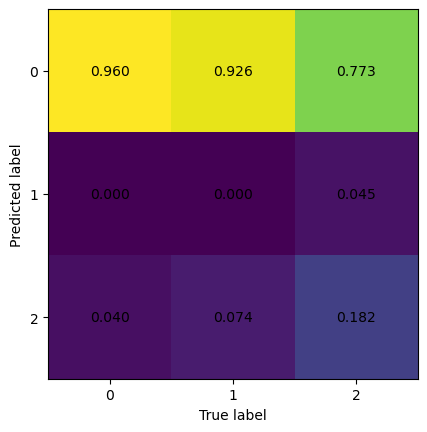

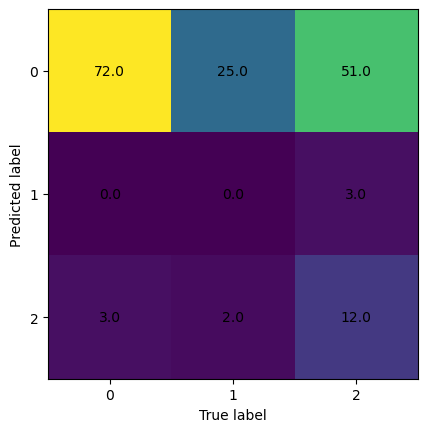

In [190]:
cm, cm_norm = confusion_matrix(targets,predictions)